<a href="https://colab.research.google.com/github/screemix/The_Glorious_Chargers/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import glob
import os
import io
import pickle
import statistics
import math
import pandas as pd
import numpy as np

import seaborn as sns

import calendar
calendar.setfirstweekday(calendar.MONDAY) # first week day

from datetime import datetime
from datetime import time
from datetime import date, timedelta

from dateutil.relativedelta import *

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pandas.tseries.offsets import *

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose


%matplotlib inline

# pandas settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, \
                                    ShuffleSplit, cross_val_predict, TimeSeriesSplit, ParameterSampler, PredefinedSplit
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import r2_score,  mean_squared_error, accuracy_score, \
                            mean_absolute_error, median_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE, RFECV, SelectFromModel

import xgboost as xgb
from xgboost import plot_importance

In [ ]:
pip install fsspec

     |████████████████████████████████| 92kB 2.3MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data upload

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_v2.csv to train_v2.csv


In [ ]:
# train_v2_ = pd.read_csv('My Drive/train_v2.csv')

In [ ]:
train_v2 = pd.read_csv(io.BytesIO(uploaded['train_v2.csv']))
train_v2.head()

,phone_id,months_with_order,months_without_order,target,gender,age
0,2,3,4,0,NaN,NaN
1,3,3,4,0,NaN,NaN
2,4,4,3,0,NaN,NaN
3,6,4,3,0,NaN,NaN
4,6,4,3,0,NaN,NaN


In [ ]:
train_v2.shape

(694524, 6)

In [31]:
train_v2 = pd.read_csv('./drive/My Drive/Colab Notebooks/NGWL The Glorious Chargers/01_preprocessed_data/train_v2.csv')
train_v2.tail()

,phone_id,months_with_order,months_without_order,last_order_month,firstt_order_month,target,gender,age
694519,719359,1,2,7,0,1,NaN,NaN
694520,719360,1,6,7,0,1,NaN,NaN
694521,719363,1,0,7,7,1,NaN,NaN
694522,719373,1,0,7,7,1,NaN,NaN
694523,719374,1,2,7,0,1,NaN,NaN


Train-test split

In [ ]:
# target and dependent variable
train_and_test_y = train_v2['target']
train_and_test_X = train_v2.drop(['target', 'phone_id', 'gender',	'age'], axis = 1)

In [ ]:
train_size = 486000

In [ ]:
train_X = train_and_test_X[0:train_size]
test_X = train_and_test_X[train_size:]
train_y = train_and_test_y[0:train_size]
test_y = train_and_test_y[train_size:]

Simple Models

In [ ]:
gbm = GradientBoostingClassifier(random_state=42)
xg = xgb.XGBClassifier(random_state=42)

models = {  
    'GBR': {'base_model': gbm},
    'XGBoost': {'base_model': xg}
}

In [ ]:
use_model = 'base_model'

In [ ]:
for model_name, model in models.items():
    print('Training {}...\n'.format(model_name))
    model[use_model].fit(train_X, train_y)
    
    importances = model[use_model].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    train_X.columns[indices]
    
    i = 1
    for idx in indices:
        if importances[idx] > 0.01:
            print('{}. {} - {}'.format(i, train_X.columns[idx], round(importances[idx], 3)))
        i+=1
    print('\n')

Training GBR...

1. months_without_order - 0.748
2. months_with_order - 0.252


Training XGBoost...

1. months_without_order - 0.7649999856948853
2. months_with_order - 0.23499999940395355




In [ ]:
gbm.fit(train_X, train_y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
score_train_GBM = gbm.predict_proba(train_X)[:, 1]
score_test_GBM =gbm.predict_proba(test_X)[:, 1]

In [ ]:
threshold_GBM = 0.5

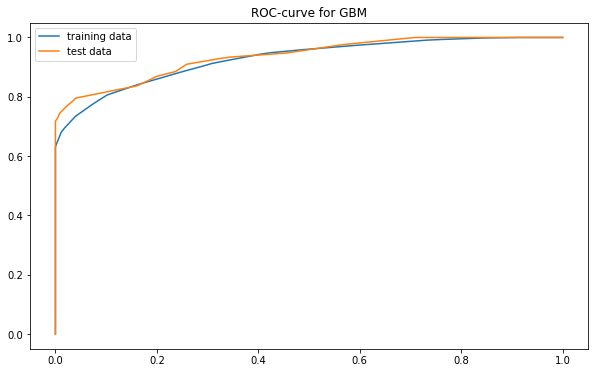

In [ ]:
# ROC Curve
fpr_train_GBM, tpr_train_GBM, thresholds_train_GBM = metrics.roc_curve(train_y, score_train_GBM, pos_label=1)
fpr_test_GBM, tpr_test_GBM, thresholds_test_GBM = metrics.roc_curve(test_y, score_test_GBM, pos_label=1)

fig = plt.figure(figsize=(10, 6))
plt.plot(fpr_train_GBM, tpr_train_GBM, label='training data')
plt.plot(fpr_test_GBM, tpr_test_GBM, label='test data')
plt.legend()
plt.title('ROC-curve for GBM')
plt.show()

For model-specific hyperparameter tuning

In [ ]:
mod_GBM = GradientBoostingClassifier(random_state=42)

search_grid_GBM = {'learning_rate': [0.05],
                   'n_estimators': [50],
                   'max_depth': [4],
                   'min_samples_leaf': [10,25,50],
                   'min_samples_split': [25,50],
                   'max_features': ['sqrt'],
                   'subsample': [0.8],
                   'random_state': [29]
                   }

In [ ]:
param_search_GBM = GridSearchCV(estimator=mod_GBM, 
                                param_grid=search_grid_GBM, 
                                scoring=metrics.make_scorer(metrics.roc_auc_score),
                                cv=3, 
                                n_jobs=-1, 
                                verbose=2,
                                return_train_score=True,
                                iid=True)

param_search_GBM.fit(X_train, y_train)

print('Optimal parameters are:')
print(param_search_GBM.best_params_)

In [ ]:
#### Creation of the model object with optimal hyperparameters

In [ ]:
mod_opt_GBM = GradientBoostingClassifier(**param_search_GBM.best_params_)
mod_opt_GBM = mod_opt_GBM.fit(X_train, y_train)

In [ ]:
# Distribution of scores by class
score_train_GBM = mod_opt_GBM.predict_proba(X_train)[:, 1]
score_test_GBM = mod_opt_GBM.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

(pd.DataFrame({'y': y_train, 'Training score': score_train_GBM})
 .boxplot(column='Training score', by='y',
          showfliers=True, ax=ax[0]))
plt.title('Training score')

(pd.DataFrame({'y': y_test, 'Test score': score_test_GBM})
 .boxplot(column='Test score', by='y', showfliers=True, ax=ax[1]))
plt.title('Test score')

plt.suptitle('Distribution of scores by class')

plt.show()

In [ ]:
# ROC Curve
fpr_train_GBM, tpr_train_GBM, thresholds_train_GBM = \
    metrics.roc_curve(y_train, score_train_GBM, pos_label=1)

fpr_test_GBM, tpr_test_GBM, thresholds_test_GBM = \
    metrics.roc_curve(y_test, score_test_GBM, pos_label=1)

fig = plt.figure(figsize=(10, 6))
plt.plot(fpr_train_GBM, tpr_train_GBM, label='training data')
plt.plot(fpr_test_GBM, tpr_test_GBM, label='test data')
plt.legend()
plt.title('ROC-curve for GBM')
plt.show()